В цій практичній роботі ми спробуємо реалізувати нейронну мережу з двох шарів (прихований і вихідний). Запропонований підхід стане заготовкою для реалізації наступних оптимізацій: MBGD, ADAM та регуляризації. 

Сьогодні ж вам пропонується додати до цього класу підтримку довільної кількості шарів та нейронів в них (наприклад, передавати їх параметром в конструктор, як це робиться в MLPClassifier за допомогою hidden_layer_sizes). Також потрібно передбачити можливість ранньої зупинки ітераційного процесу, якщо значення штрафної функції не покращуватиметься протягом певної кількості ітерацій. Наприклад, якщо протягом $k$ ітерацій штрафна функція за модулем не стане меншою, ніж на поточному кроці.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

In [2]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [3]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [4]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, normalize = True, learning_rate = 0.01, num_iter = 30000, hidden_layer_sizes = (10,), eps = 1e-6):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.layers_len = len(hidden_layer_sizes) + 1
        self.eps = eps
        self.parameters = None  # W and b
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __initialize_parameters(self, n_x, n_y):
        W_arr = []
        b_arr = []
        self.dW = []
        self.db = []
        
        W1 = np.random.randn(n_y[0], n_x)*0.01;
        b1 = np.zeros((n_y[0], 1));
        W_arr.append(W1);
        b_arr.append(b1);
        
        for i in range(1,len(n_y)):
            W_temp =np.random.randn(n_y[i], n_y[i-1]) * 0.01;
            b_temp = np.zeros((n_y[i], 1));
            W_arr.append(W_temp);
            b_arr.append(b_temp);
        
        W2 = np.random.randn(1, n_y[len(n_y)-1]) * 0.01
        b2 = 0
        
        W_arr.append(W2);
        b_arr.append(b2);
        
        self.parameters = {"W" : W_arr, "b" : b_arr}
        
       
    def __forward_propagation(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]
        
        Z = list()
        A = list()
        
        Z.append(np.dot(W[0], X) + b[0])
        A.append(self.__sigmoid(Z[0]))

        for i in range(1, self.layers_len):
            Z.append(np.dot(W[i], A[i-1]) + b[i])
            A.append(self.__sigmoid(Z[i]))
            
        cache = (W, b, Z, A)
        return A[-1], cache
    
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
        
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None for i in range(self.layers_len)]
        db = [None for i in range(self.layers_len)]
        dZ = [None for i in range(self.layers_len)]
        dA = [None for i in range(self.layers_len)]
        
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for i in range(self.layers_len-1, 1, -1):
            dZ[i-1] = np.multiply(dA[i], np.multiply(A[i-1], 1 - A[i-1]))
            dW[i-1] = 1. / m * np.dot(dZ[i-1], A[i-2].T)
            db[i-1] = 1. / m * np.sum(dZ[i-1], axis = 1, keepdims = True)
            dA[i-1] = np.dot(W[i-1].T, dZ[i-1])
            
        dZ[0] = np.multiply(dA[1], np.multiply(A[0], 1 - A[0]))
        dA[0] = np.dot(W[0].T, dZ[0])
        
        dW[0] = 1. / m * np.dot(dZ[0], X.T)
        db[0] = 1. / m * np.sum(dZ[0], axis = 1, keepdims = True)
    
        grads = {"dZ": dZ, "dW": dW, "db": db}
        return grads
    
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]
        
        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.layers_len):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]
        
        self.parameters = {"W": W, "b": b}

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        costs_history = []
        m = X.shape[1]
        n_x = X.shape[0]
        self.__initialize_parameters(n_x, self.hidden_layer_sizes)

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)
            cost = self.compute_cost(A, Y)
            grads = self.__backward_propagation(X, Y, cache)
            self.__update_parameters(grads)
            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))
            if i % 1000 == 0:
                costs.append(cost)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0]
        
        return np.column_stack((probs.T, 1 - probs.T))
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)[:, 0]
        return (positive_probs >= 0.5).astype(int)

Спочатку спробуйте цей клас на одній задачі, а потім на іншій.

In [5]:
#data_columns = ["exam1", "exam2"]
#target_column = "submitted"
#df = pd.read_csv("sats.csv")
#X, Y = df[data_columns].values, df[target_column].reshape((df.shape[0], 1))
#print('Training set: X={}, y={}'.format(X.shape, Y.shape))

In [6]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(118, 2), y=(118,)


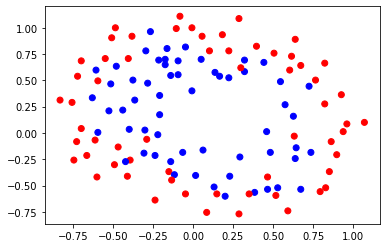

In [7]:
plot_data(X, Y)

In [8]:
cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000, hidden_layer_sizes=(20,), eps=1e-6)

0-th iteration: 0.6934596428628518
1000-th iteration: 0.6893735568975126
2000-th iteration: 0.5826744788371627
3000-th iteration: 0.39058827681438496


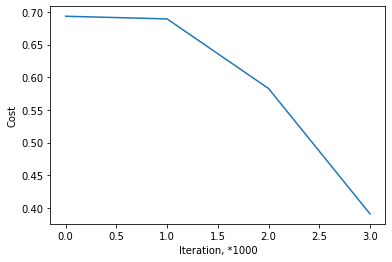

In [9]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))

In [10]:
print(cls.parameters)

{'W': [array([[ 0.919744  , -0.40052156],
       [ 0.13252403,  0.00718786],
       [ 0.19433282,  0.04510371],
       [ 1.83301169,  1.48088554],
       [ 0.08958555, -1.60960115],
       [ 0.30059879, -0.01571768],
       [ 0.06164205, -0.01917731],
       [ 0.28185882,  0.07191367],
       [ 1.02537857, -0.80273897],
       [ 0.2518954 ,  1.35859431],
       [ 0.39888173, -2.91250996],
       [ 0.40800046,  0.16191445],
       [-1.91314322, -0.50638333],
       [ 0.23432477,  0.06769149],
       [ 0.59319053,  0.11482741],
       [ 1.61334024, -0.26721677],
       [ 0.06584509, -0.03587591],
       [ 0.19441502, -1.97148191],
       [ 0.2798974 ,  0.45434727],
       [ 0.13078995,  0.1174794 ]]), array([[ 6.78893285e-01, -6.97230174e-01, -6.29985819e-01,
        -9.26095167e+00, -6.36391718e+00, -6.53898323e-01,
        -8.04756614e-01, -3.28228561e-01,  1.97052425e+00,
         1.63755145e+00, -3.60074786e+00, -9.36049186e-02,
        -3.38425368e+00, -5.59771635e-01,  1.27590496e-

In [11]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[0.57019526, 0.42980474],
       [0.80223211, 0.19776789],
       [0.3833654 , 0.6166346 ],
       [0.20000247, 0.79999753],
       [0.11644336, 0.88355664],
       [0.85336217, 0.14663783],
       [0.04263176, 0.95736824],
       [0.24609256, 0.75390744],
       [0.76309348, 0.23690652],
       [0.93251161, 0.06748839],
       [0.97101355, 0.02898645],
       [0.32007081, 0.67992919],
       [0.23597698, 0.76402302],
       [0.11102123, 0.88897877],
       [0.77774452, 0.22225548],
       [0.20821249, 0.79178751],
       [0.60588403, 0.39411597],
       [0.83465653, 0.16534347],
       [0.73432817, 0.26567183],
       [0.19353315, 0.80646685],
       [0.9952008 , 0.0047992 ],
       [0.8459371 , 0.1540629 ],
       [0.82712386, 0.17287614],
       [0.06464299, 0.93535701],
       [0.27011351, 0.72988649],
       [0.86440833, 0.13559167],
       [0.18258142, 0.81741858],
       [0.34435116, 0.65564884],
       [0.42341097, 0.57658903],
       [0.83547407, 0.16452593],
       [0.

In [12]:
Y_hat = cls.predict(X)
Y_hat

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 0, 0])

In [13]:
accuracy_score(Y, Y_hat)

0.864406779661017

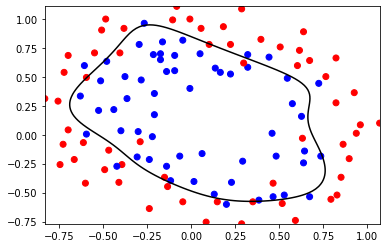

In [14]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [15]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (5,10,), max_iter = 10000, activation = 'relu', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

In [16]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(5, 10), learning_rate_init=0.01,
              max_iter=10000, solver='sgd')

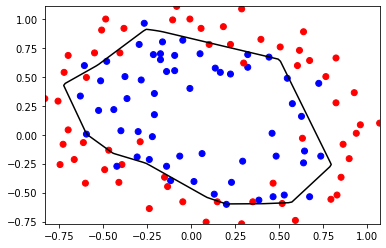

In [17]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [18]:
accuracy_score(Y, clf.predict(X))

0.8559322033898306

In [19]:
clf.n_iter_

1308

Dataset 2

In [20]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
df = pd.read_csv("sats.csv")
X, Y = df[data_columns].values, df[target_column]
print('Training set: X={}, y={}'.format(X.shape, Y.shape))

Training set: X=(100, 2), y=(100,)


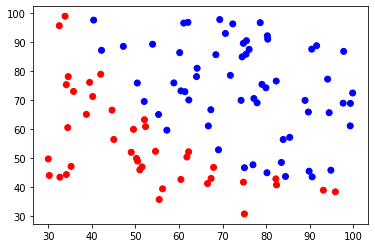

In [21]:
plot_data(X, Y)


In [22]:

cls = NeuralNet(normalize = True, learning_rate = 0.5, num_iter = 4000, hidden_layer_sizes=(100,), eps=1e-6)

0-th iteration: 0.6975819674990892
1000-th iteration: 0.6710157070593047
2000-th iteration: 0.551621565040289
3000-th iteration: 0.2539834150538274


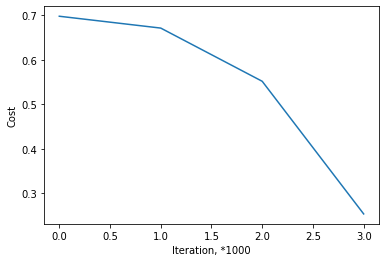

In [23]:
cls.fit(X, Y.values.reshape((df.shape[0], 1)))


In [24]:
print(cls.parameters)

{'W': [array([[ 2.5009367 ,  2.19999556],
       [-0.56712006, -0.50428622],
       [ 1.03655129,  0.93106723],
       [ 0.12177764,  0.11557966],
       [-0.56587128, -0.49887412],
       [ 0.67662893,  0.59316214],
       [-1.48641264, -1.29417489],
       [ 0.50873393,  0.44364844],
       [-2.07013089, -1.81640962],
       [ 0.57345264,  0.52171772],
       [-0.5736835 , -0.50687514],
       [ 0.82249429,  0.7255456 ],
       [-1.34830738, -1.18132521],
       [-0.60056236, -0.54289131],
       [ 1.08294937,  0.91448621],
       [ 1.15282165,  1.03290699],
       [ 0.91942065,  0.82275843],
       [ 0.06040559,  0.03799225],
       [ 0.94152386,  0.83627302],
       [-1.74133441, -1.51949171],
       [-2.06942169, -1.81477712],
       [ 1.78651343,  1.55834877],
       [ 1.69630247,  1.49250852],
       [ 0.10264838,  0.09574943],
       [-1.29834745, -1.14679302],
       [ 1.33466921,  1.18775174],
       [ 1.22503912,  1.06816883],
       [ 0.20719502,  0.1835754 ],
       [ 0.56

In [25]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[1.69275526e-01, 8.30724474e-01],
       [1.09195199e-03, 9.98908048e-01],
       [1.07293250e-01, 8.92706750e-01],
       [9.59915965e-01, 4.00840348e-02],
       [9.87166317e-01, 1.28336834e-02],
       [4.39993315e-02, 9.56000669e-01],
       [9.90981929e-01, 9.01807121e-03],
       [4.56897384e-01, 5.43102616e-01],
       [9.96210391e-01, 3.78960916e-03],
       [6.79084713e-01, 3.20915287e-01],
       [8.38195337e-01, 1.61804663e-01],
       [8.62061063e-02, 9.13793894e-01],
       [9.93028187e-01, 6.97181289e-03],
       [9.97582014e-01, 2.41798636e-03],
       [2.37548131e-01, 7.62451869e-01],
       [9.36583402e-01, 6.34165984e-02],
       [4.57744194e-01, 5.42255806e-01],
       [2.38492029e-01, 7.61507971e-01],
       [9.96148791e-01, 3.85120917e-03],
       [5.61013692e-01, 4.38986308e-01],
       [1.45699175e-01, 8.54300825e-01],
       [9.89469520e-01, 1.05304799e-02],
       [3.46741530e-02, 9.65325847e-01],
       [1.95607234e-03, 9.98043928e-01],
       [9.649633

In [26]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1])

In [27]:
accuracy_score(Y, Y_hat)

0.89

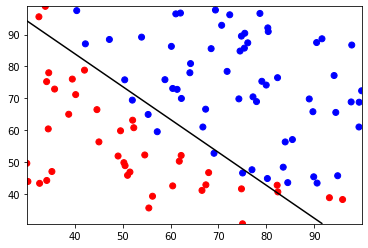

In [28]:
plot_data(X, Y)
plot_surface(cls, X[:, 0], X[:, 1])

In [29]:

from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (650,), max_iter = 10000, activation = 'tanh', solver = 'sgd', learning_rate_init = 0.0005, learning_rate = 'constant')

In [30]:
clf.fit(X, Y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(650,),
              learning_rate_init=0.0005, max_iter=10000, solver='sgd')

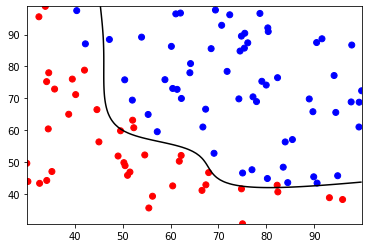

In [31]:
plot_data(X, Y)
plot_surface(clf, X[:, 0], X[:, 1])

In [32]:
accuracy_score(Y, clf.predict(X))

0.95